In [1]:
import google.protobuf
print("Protobuf installed successfully!")

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import Sequence
from tkinter import filedialog
from PIL import Image, ImageTk
import tkinter as tk

ModuleNotFoundError: No module named 'google'

In [24]:
# إعداد البيانات
data_dir = r"C:\Users\NTC\OneDrive\Desktop\University\4th Year\Deep Learning\projects\Brain Tumor\dataset\Training"
img_size = (224, 224)
batch_size = 32

In [26]:
# التحقق من وجود مسار البيانات
if os.path.exists(data_dir):
    print("Dataset path is valid!")
else:
    print("Dataset path is invalid. Please check the directory.")

Dataset path is valid!


In [30]:
# تحضير البيانات مع التوسيع والتطبيع
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    validation_split=0.2,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True
)

In [32]:
train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=batch_size,
    subset="training",
    class_mode="categorical"
)

Found 2297 images belonging to 4 classes.


In [34]:
val_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=batch_size,
    subset="validation",
    class_mode="categorical"
)

Found 573 images belonging to 4 classes.


In [36]:
# تحميل نموذج InceptionV3 (Transfer Learning)
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [38]:
# إضافة الطبقات النهائية
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(4, activation='softmax')(x)

model_inception = Model(inputs=base_model.input, outputs=predictions)

In [40]:
# تجميد طبقات InceptionV3
for layer in base_model.layers:
    layer.trainable = False

In [42]:
# تجميع النموذج
model_inception.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [46]:
# إضافة callbacks (EarlyStopping و ModelCheckpoint)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True)

In [48]:
# التدريب
history = model_inception.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=[early_stopping, checkpoint]
)

Epoch 1/2
72/72 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - accuracy: 0.5018 - loss: 2.1088 - val_accuracy: 0.6946 - val_loss: 0.7376
Epoch 2/2
72/72 ━━━━━━━━━━━━━━━━━━━━ 79s 1s/step - accuracy: 0.7702 - loss: 0.6003 - val_accuracy: 0.6981 - val_loss: 0.6871


In [50]:
# حفظ النموذج
model_inception.save("brain_tumor_classifier.h5")

In [52]:
# تقييم النموذج
def evaluate_model(model, val_generator):
    val_generator.reset()
    predictions = model.predict(val_generator)
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = val_generator.classes
    class_names = val_generator.class_indices
    class_names = {v: k for k, v in class_names.items()}

    print("\nClassification Report:")
    print(classification_report(true_classes, predicted_classes))

    print("\nConfusion Matrix:")
    cm = confusion_matrix(true_classes, predicted_classes)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=list(class_names.values()), yticklabels=list(class_names.values()))
    plt.ylabel('True Class')
    plt.xlabel('Predicted Class')
    plt.show()

    # رسم دقة التدريب والخسارة
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.show()

18/18 ━━━━━━━━━━━━━━━━━━━━ 17s 831ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.29      0.27      0.28       165
           1       0.28      0.36      0.32       164
           2       0.14      0.09      0.11        79
           3       0.28      0.27      0.28       165

    accuracy                           0.27       573
   macro avg       0.25      0.25      0.24       573
weighted avg       0.26      0.27      0.26       573


Confusion Matrix:


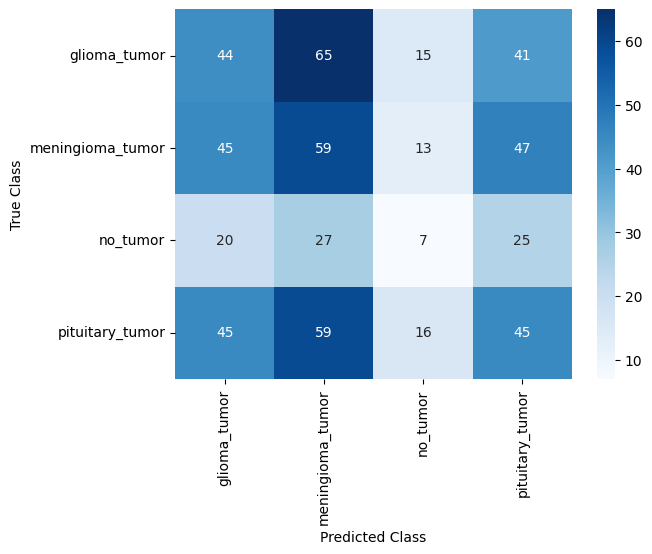

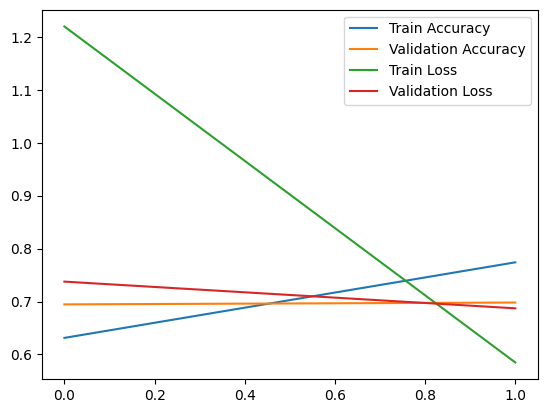

In [54]:
# استدعاء دالة التقييم
evaluate_model(model_inception, val_generator)


In [56]:
# واجهة المستخدم لتصنيف الصورة
class_names = ['Glioma Tumor', 'Meningioma Tumor', 'No Tumor', 'Pituitary Tumor']
model_inception = tf.keras.models.load_model("brain_tumor_classifier.keras")

In [58]:
def classify_image():
    file_path = filedialog.askopenfilename()
    if file_path:
        img = Image.open(file_path).resize((224, 224))
        img_array = np.array(img) / 255.0
        img_array = np.expand_dims(img_array, axis=0)
        prediction = model_inception.predict(img_array)
        class_idx = np.argmax(prediction)
        result_label.config(text=f"Prediction: {class_names[class_idx]}")
        img_display = ImageTk.PhotoImage(img)
        image_label.config(image=img_display)
        image_label.photo = img_display


In [60]:
# واجهة المستخدم
root = tk.Tk()
root.title("Brain Tumor Classifier")

frame = tk.Frame(root)
frame.pack()

upload_btn = tk.Button(frame, text="Upload Image", command=classify_image)
upload_btn.pack()

image_label = tk.Label(frame)
image_label.pack()

result_label = tk.Label(frame, text="Prediction: None", font=("Arial", 14))
result_label.pack()

root.mainloop()


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
